In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
data = pd.read_csv('D:/datasets/train.csv')

C:\Users\enith\AppData\Local\Temp\ipykernel_17344\1200592324.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) 

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape
Y_train

array([3, 3, 7, ..., 4, 6, 3], dtype=int64)

In [3]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return (np.sum(predictions == Y) / Y.size)*100

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    accuracy_history = []
    loss_history = []
    precision_history = []
    recall_history = []

    for i in range(iterations):
        with tf.device('/device:GPU:0'):
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print("Accuracy: ", accuracy)
            accuracy_history.append(accuracy)

            loss = compute_loss(A2, Y)
            print("Loss: ", loss)
            loss_history.append(loss)

            confusion_matrix = compute_confusion_matrix(predictions, Y)
            precision, recall = compute_precision_recall(confusion_matrix)
            precision_history.append(precision)
            recall_history.append(recall)

    return W1, b1, W2, b2, accuracy_history, loss_history, precision_history, recall_history

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [4]:
def compute_precision_recall(confusion_matrix):
    precision = np.zeros(confusion_matrix.shape[0])
    recall = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        precision[i] = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

def compute_loss(A2, Y):
    one_hot_Y = one_hot(Y)
    loss = -np.sum(one_hot_Y * np.log(A2)) / Y.size
    return loss

def compute_confusion_matrix(predictions, Y):
    classes = np.unique(Y)
    confusion_matrix = np.zeros((len(classes), len(classes)))
    for i in range(len(classes)):
        for j in range(len(classes)):
            confusion_matrix[i, j] = np.sum((predictions == classes[j]) & (Y == classes[i]))
    return confusion_matrix

In [5]:
W1, b1, W2, b2, accuracy_history, loss_history, precision_history, recall_history = gradient_descent(X_train, Y_train, 0.1, 1500)

Iteration:  0
Accuracy:  12.324390243902439
Loss:  3.377485937470583
Iteration:  10
Accuracy:  20.953658536585365
Loss:  2.245910646479667
Iteration:  20
Accuracy:  29.902439024390244
Loss:  1.982702872608452
Iteration:  30
Accuracy:  41.224390243902434
Loss:  1.774026897435205
Iteration:  40
Accuracy:  49.1
Loss:  1.5861350463287613
Iteration:  50
Accuracy:  53.88048780487805
Loss:  1.4317207281294284
Iteration:  60
Accuracy:  57.31463414634146
Loss:  1.309967009550344
Iteration:  70
Accuracy:  60.229268292682924
Loss:  1.2127743253882004
Iteration:  80
Accuracy:  62.673170731707316
Loss:  1.1334116104827037
Iteration:  90
Accuracy:  64.72439024390243
Loss:  1.0676321993943543
Iteration:  100
Accuracy:  66.31219512195122
Loss:  1.012130985536121
Iteration:  110
Accuracy:  67.82682926829268
Loss:  0.9649234019491284
Iteration:  120
Accuracy:  69.17560975609756
Loss:  0.9243010303425745
Iteration:  130
Accuracy:  70.39268292682927
Loss:  0.8889097856676448
Iteration:  140
Accuracy:  71.

Prediction:  [4]
Label:  4


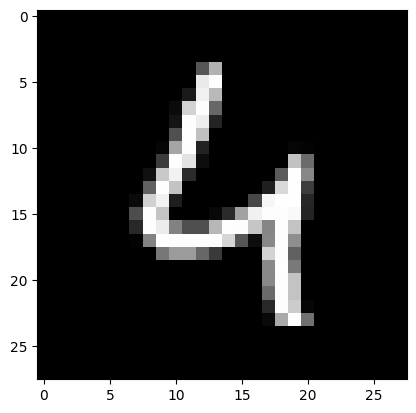

Prediction:  [6]
Label:  6


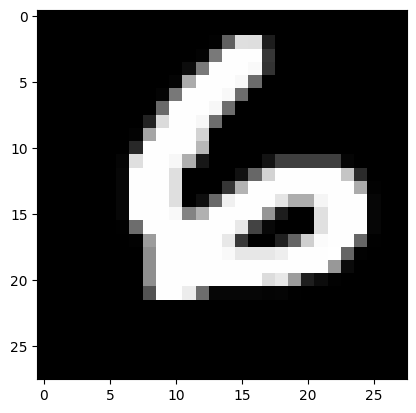

Prediction:  [1]
Label:  2


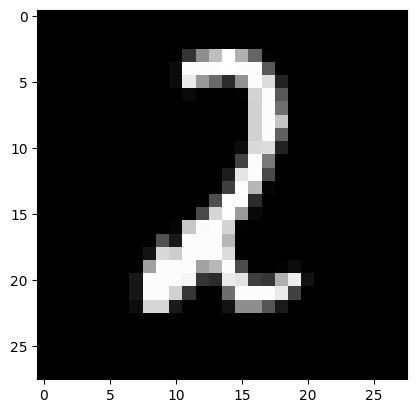

Prediction:  [0]
Label:  0


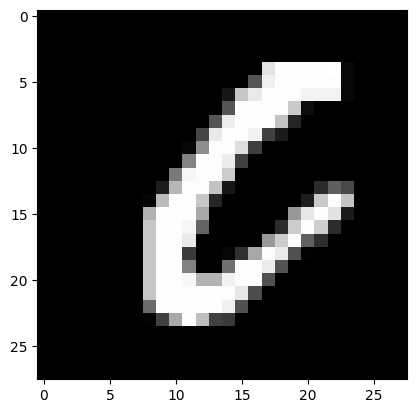

In [6]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [7]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)

In [8]:
print("Accuracy:",get_accuracy(dev_predictions, Y_dev))

Accuracy: 69.19999999999999


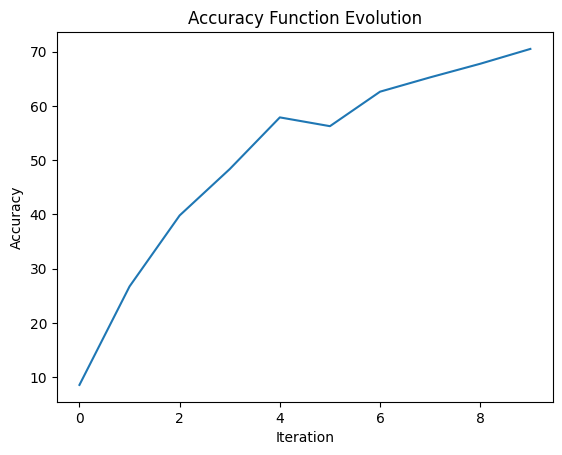

In [9]:
# Plot accuracy function evolution
plt.figure()
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.title('Accuracy Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

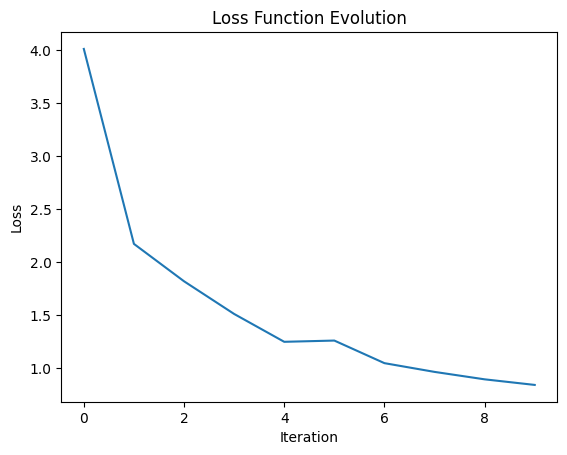

In [10]:
# Plot loss function evolution
plt.figure()
plt.plot(range(len(loss_history)), loss_history)
plt.title('Loss Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

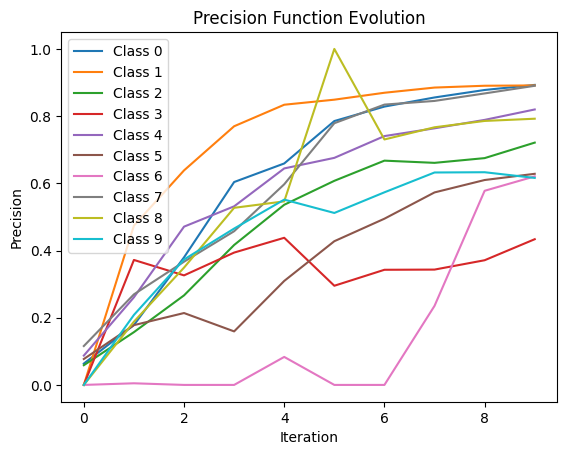

In [11]:
# Plot precision function evolution
plt.figure()
precision_history = np.array(precision_history)
for i in range(precision_history.shape[1]):
    plt.plot(range(len(precision_history)), precision_history[:, i], label=f'Class {i}')
plt.title('Precision Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.legend()
plt.show()

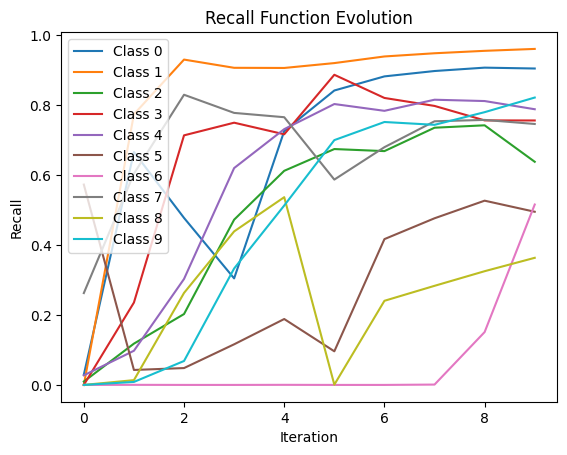

In [12]:
# Plot recall function evolution
plt.figure()
recall_history = np.array(recall_history)
for i in range(recall_history.shape[1]):
    plt.plot(range(len(recall_history)), recall_history[:, i], label=f'Class {i}')
plt.title('Recall Function Evolution')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [13]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
print("Accuracy on dev set:", get_accuracy(dev_predictions, Y_dev))

confusion_matrix = compute_confusion_matrix(dev_predictions, Y_dev)
print("Confusion Matrix:")
print(confusion_matrix)

Accuracy on dev set: 69.19999999999999
Confusion Matrix:
[[83.  0.  1.  4.  0.  3.  0.  0.  0.  1.]
 [ 1. 86.  0.  1.  0.  0.  0.  0.  0.  1.]
 [ 4.  5. 60.  3.  7.  1. 25.  3.  1.  0.]
 [ 0.  0.  3. 72.  1.  7.  3.  1.  5.  2.]
 [ 1.  0.  1.  1. 82.  0.  2.  0.  0. 12.]
 [ 3.  1.  1. 43.  1. 41.  3.  0.  0.  6.]
 [ 1.  1.  5. 17.  1.  5. 76.  0.  0.  0.]
 [ 0.  3.  1.  0.  3.  0.  0. 73.  5. 18.]
 [ 0.  2.  1. 45.  0.  9.  6.  1. 45.  6.]
 [ 2.  0.  0.  1. 10.  1.  0.  6.  0. 74.]]


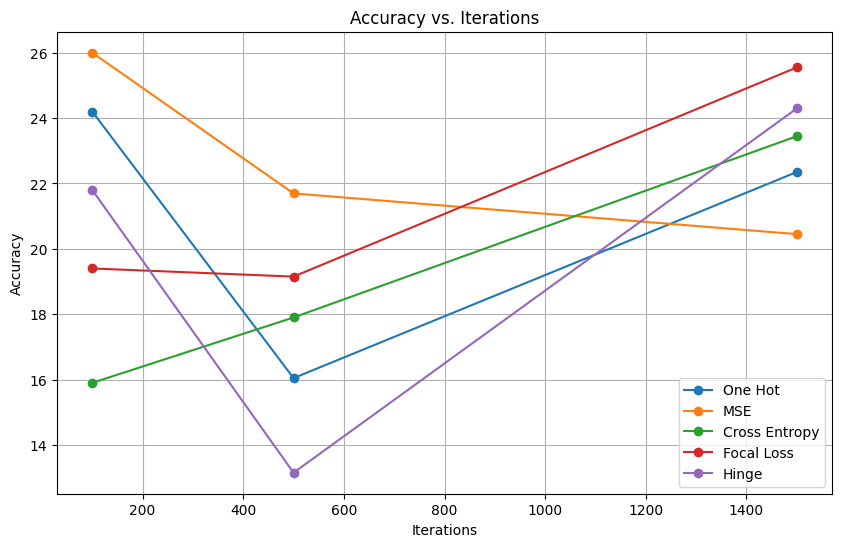

In [14]:
import matplotlib.pyplot as plt
#quantized
# Data
iterations = [1500, 500, 100]
one_hot_accuracy = [22.35, 16.045, 24.2]
mse_accuracy = [20.45, 21.695, 26]
cross_entropy_accuracy = [23.445, 17.9, 15.9]
focal_loss_accuracy = [25.55, 19.15, 19.4]
hinge_accuracy = [24.295, 13.15, 21.8]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(iterations, one_hot_accuracy, marker='o', label='One Hot')
plt.plot(iterations, mse_accuracy, marker='o', label='MSE')
plt.plot(iterations, cross_entropy_accuracy, marker='o', label='Cross Entropy')
plt.plot(iterations, focal_loss_accuracy, marker='o', label='Focal Loss')
plt.plot(iterations, hinge_accuracy, marker='o', label='Hinge')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()


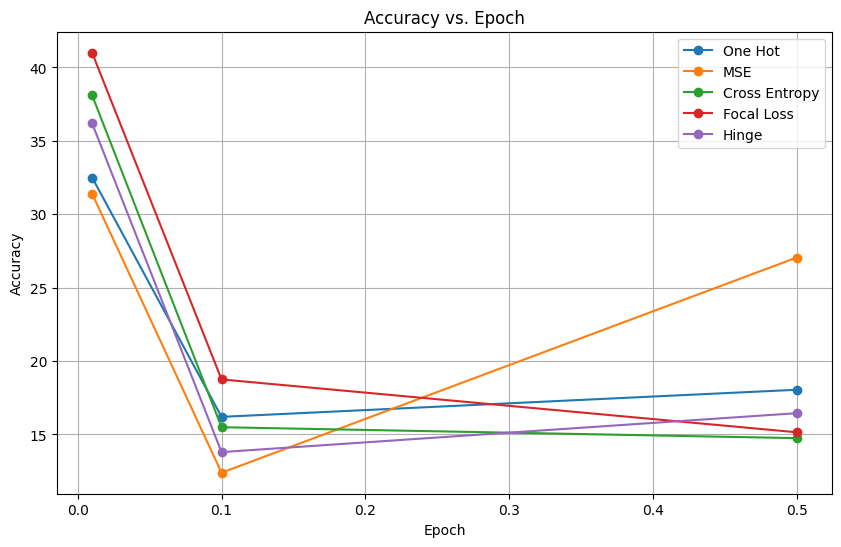

In [15]:
import matplotlib.pyplot as plt

# Data
epochs = [0.01, 0.1, 0.5]
one_hot_accuracy = [32.5, 16.2, 18.045]
mse_accuracy = [31.4, 12.395, 27.05]
cross_entropy_accuracy = [38.1, 15.495, 14.75]
focal_loss_accuracy = [41, 18.75, 15.15]
hinge_accuracy = [36.19, 13.8, 16.45]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, one_hot_accuracy, marker='o', label='One Hot')
plt.plot(epochs, mse_accuracy, marker='o', label='MSE')
plt.plot(epochs, cross_entropy_accuracy, marker='o', label='Cross Entropy')
plt.plot(epochs, focal_loss_accuracy, marker='o', label='Focal Loss')
plt.plot(epochs, hinge_accuracy, marker='o', label='Hinge')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


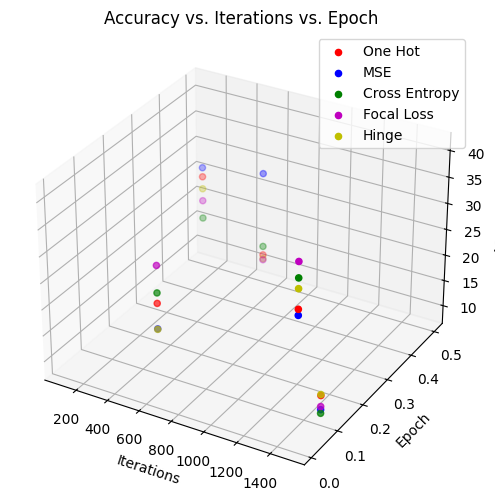

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data
iterations = [1500, 1500, 500, 500, 100]
epochs = [0.01, 0.1, 0.1, 0.5, 0.5]
one_hot_accuracy = [32.5, 12.2, 20.2, 11.89, 24.2]
mse_accuracy = [31.4, 9.5, 15.29, 28.1, 26]
cross_entropy_accuracy = [38.1, 8.79, 22.2, 13.6, 15.9]
focal_loss_accuracy = [41, 10.1, 27.4, 10.9, 19.4]
hinge_accuracy = [36.19, 12.4, 15.2, 11.1, 21.8]

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(iterations, epochs, one_hot_accuracy, c='r', marker='o', label='One Hot')
ax.scatter(iterations, epochs, mse_accuracy, c='b', marker='o', label='MSE')
ax.scatter(iterations, epochs, cross_entropy_accuracy, c='g', marker='o', label='Cross Entropy')
ax.scatter(iterations, epochs, focal_loss_accuracy, c='m', marker='o', label='Focal Loss')
ax.scatter(iterations, epochs, hinge_accuracy, c='y', marker='o', label='Hinge')

ax.set_xlabel('Iterations')
ax.set_ylabel('Epoch')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy vs. Iterations vs. Epoch')
ax.legend()

plt.show()


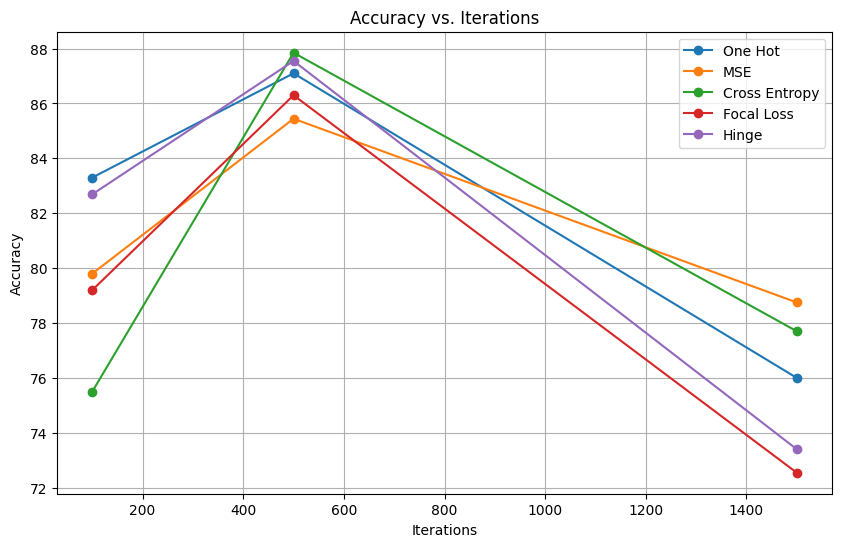

In [16]:
import matplotlib.pyplot as plt
#pruned
# Data
iterations = [1500, 500, 100]
one_hot_accuracy = [76,87.1,83.3]
mse_accuracy = [78.75,85.445,79.8]
cross_entropy_accuracy = [77.7,87.85,75.5]
focal_loss_accuracy = [72.545,86.3,79.2]
hinge_accuracy = [73.4,87.55,82.69]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(iterations, one_hot_accuracy, marker='o', label='One Hot')
plt.plot(iterations, mse_accuracy, marker='o', label='MSE')
plt.plot(iterations, cross_entropy_accuracy, marker='o', label='Cross Entropy')
plt.plot(iterations, focal_loss_accuracy, marker='o', label='Focal Loss')
plt.plot(iterations, hinge_accuracy, marker='o', label='Hinge')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()


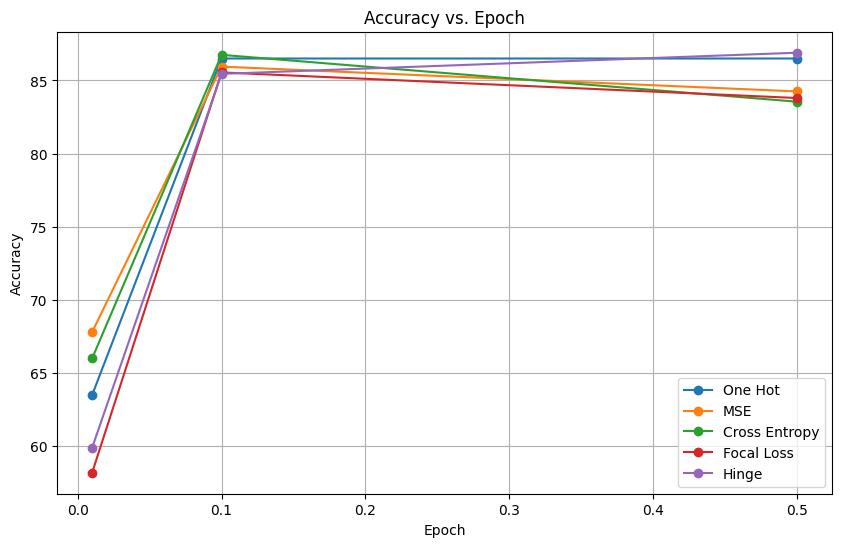

In [17]:
# Data
epochs = [0.01, 0.1, 0.5]
one_hot_accuracy = [63.5,86.5,86.5]
mse_accuracy = [67.8,85.945,84.25]
cross_entropy_accuracy = [66,86.75,83.55]
focal_loss_accuracy = [58.19,85.55,83.8]
hinge_accuracy = [59.9,85.45,86.895]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, one_hot_accuracy, marker='o', label='One Hot')
plt.plot(epochs, mse_accuracy, marker='o', label='MSE')
plt.plot(epochs, cross_entropy_accuracy, marker='o', label='Cross Entropy')
plt.plot(epochs, focal_loss_accuracy, marker='o', label='Focal Loss')
plt.plot(epochs, hinge_accuracy, marker='o', label='Hinge')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


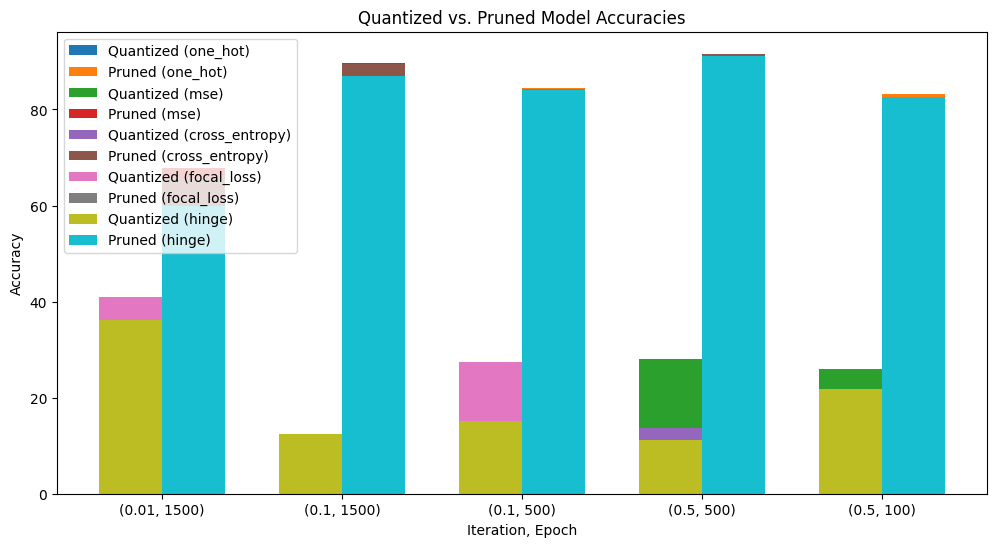

In [1]:
import matplotlib.pyplot as plt
import numpy as np

iterations = [1500, 1500, 500, 500, 100]
epochs = [0.01, 0.1, 0.1, 0.5, 0.5]

quantized_model_accuracies = {
    'one_hot': [32.5, 12.2, 20.2, 11.89, 24.2],
    'mse': [31.4, 9.5, 15.29, 28.1, 26.0],
    'cross_entropy': [38.1, 8.79, 22.2, 13.6, 15.9],
    'focal_loss': [41.0, 10.1, 27.4, 10.9, 19.4],
    'hinge': [36.19, 12.4, 15.2, 11.1, 21.8]
}

pruned_model_accuracies = {
    'one_hot': [63.5, 88.5, 84.5, 89.7, 83.3],
    'mse': [67.8, 89.7, 82.19, 88.7, 79.8],
    'cross_entropy': [66.0, 89.4, 84.1, 91.6, 75.5],
    'focal_loss': [58.19, 86.9, 84.2, 88.4, 79.2],
    'hinge': [59.9, 86.9, 84.0, 91.1, 82.69]
}

loss_funcs = list(quantized_model_accuracies.keys())
x = np.arange(len(iterations))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

for i, loss_func in enumerate(loss_funcs):
    quantized_accuracies = quantized_model_accuracies[loss_func]
    pruned_accuracies = pruned_model_accuracies[loss_func]
    
    ax.bar(x - width/2, quantized_accuracies, width, label=f'Quantized ({loss_func})')
    ax.bar(x + width/2, pruned_accuracies, width, label=f'Pruned ({loss_func})')

ax.set_xticks(x)
ax.set_xticklabels([f'({epoch}, {iteration})' for epoch, iteration in zip(epochs, iterations)])
ax.legend()
ax.set_xlabel('Iteration, Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Quantized vs. Pruned Model Accuracies')

plt.show()

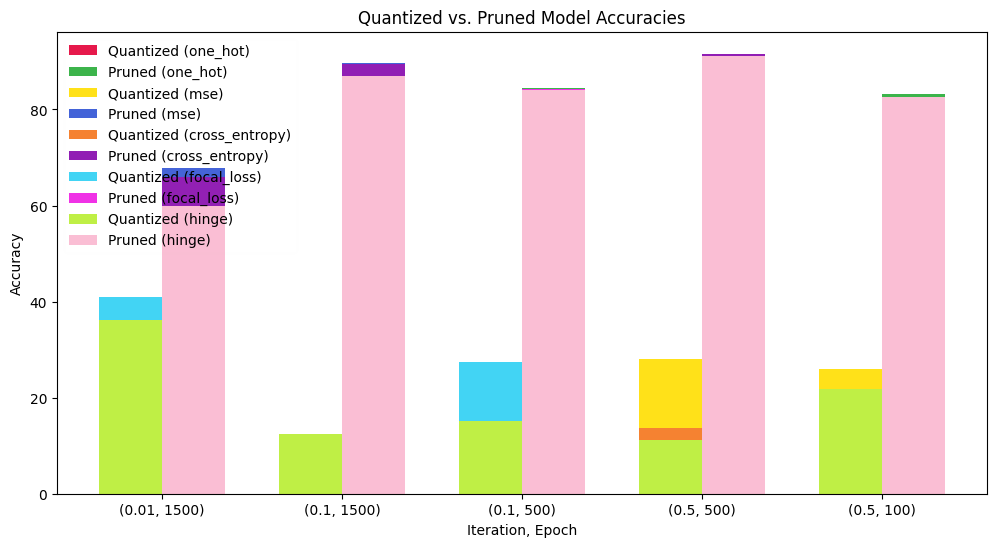

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

iterations = [1500, 1500, 500, 500, 100]
epochs = [0.01, 0.1, 0.1, 0.5, 0.5]

quantized_model_accuracies = {
    'one_hot': [32.5, 12.2, 20.2, 11.89, 24.2],
    'mse': [31.4, 9.5, 15.29, 28.1, 26.0],
    'cross_entropy': [38.1, 8.79, 22.2, 13.6, 15.9],
    'focal_loss': [41.0, 10.1, 27.4, 10.9, 19.4],
    'hinge': [36.19, 12.4, 15.2, 11.1, 21.8]
}

pruned_model_accuracies = {
    'one_hot': [63.5, 88.5, 84.5, 89.7, 83.3],
    'mse': [67.8, 89.7, 82.19, 88.7, 79.8],
    'cross_entropy': [66.0, 89.4, 84.1, 91.6, 75.5],
    'focal_loss': [58.19, 86.9, 84.2, 88.4, 79.2],
    'hinge': [59.9, 86.9, 84.0, 91.1, 82.69]
}

loss_funcs = list(quantized_model_accuracies.keys())
x = np.arange(len(iterations))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Define color palettes
color_palettes = [
    ['#e6194b', '#3cb44b'],  # Red and green
    ['#ffe119', '#4363d8'],  # Yellow and blue
    ['#f58231', '#911eb4'],  # Orange and purple
    ['#42d4f4', '#f032e6'],  # Cyan and magenta
    ['#bfef45', '#fabed4']   # Light green and light pink
]

for i, (loss_func, palette) in enumerate(zip(loss_funcs, color_palettes)):
    quantized_accuracies = quantized_model_accuracies[loss_func]
    pruned_accuracies = pruned_model_accuracies[loss_func]
    
    cmap = ListedColormap(palette)
    ax.bar(x - width/2, quantized_accuracies, width, label=f'Quantized ({loss_func})', color=palette[0])
    ax.bar(x + width/2, pruned_accuracies, width, label=f'Pruned ({loss_func})', color=palette[1])

ax.set_xticks(x)
ax.set_xticklabels([f'({epoch}, {iteration})' for epoch, iteration in zip(epochs, iterations)])
ax.legend(framealpha=0.01)  # Transparent legend box
ax.set_xlabel('Iteration, Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Quantized vs. Pruned Model Accuracies')

plt.show()